<a href="https://colab.research.google.com/github/lhiwi/portfolio-forecast/blob/task-1/notebooks/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Preprocessing & EDA (TSLA, BND, SPY | 2015-07-01 to 2025-07-31)

In [47]:
!pip -q install yfinance==0.2.50 pandas_datareader==0.10.0 statsmodels==0.14.2


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import yfinance as yf
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller
import json
import time

In [49]:
# Plot defaults (clean and simple)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
plt.rcParams["figure.figsize"] = (10, 4)

In [50]:
# Project window
START, END = "2015-07-01", "2025-07-31"

# We’ll present columns as TSLA / BND / SPY in all downstream code,
# even if we use a proxy symbol under the hood.
ROLE_TICKERS = {
    "TSLA": ["TSLA.US"],                   # Tesla on Stooq
    "BND" : ["BND.US"],                    # Vanguard Total Bond Market ETF on Stooq
    "SPY" : ["SPY.US", "VOO.US", "IVV.US"] # S&P 500 proxies on Stooq
}

# Fetch from Stooq (single source, no yfinance)

In [51]:
def fetch_stooq_one(sym: str, start: str, end: str) -> pd.DataFrame | None:
    """
    Fetches OHLCV from Stooq via pandas_datareader.
    Returns a tidy DataFrame with columns: Date, Open, High, Low, Close, Volume.
    Returns None if no data is available.
    """
    try:
        df = pdr.DataReader(sym, "stooq", start=start, end=end)   # returns Desc order by default
        if df is None or df.empty:
            return None
        df = df.sort_index().rename_axis("Date").reset_index()
        # Ensure required columns exist (Stooq provides them, but we guard anyway)
        for col in ["Open","High","Low","Close","Volume"]:
            if col not in df.columns:
                df[col] = 0.0 if col == "Volume" else np.nan
        # Keep only what we need
        return df[["Date","Open","High","Low","Close","Volume"]]
    except Exception:
        return None

def fetch_by_role_stooq(role_map: dict[str, list[str]], start: str, end: str) -> tuple[pd.DataFrame, dict]:
    """
    Try a sequence of Stooq symbols for each role (TSLA/BND/SPY).
    Returns:
      - concatenated tidy DataFrame with a canonical 'Ticker' column (roles)
      - a dict mapping role -> {symbol: chosen_symbol, source: "stooq"}
    Raises RuntimeError if a role cannot be fetched by any candidate symbol.
    """
    frames, used = [], {}
    for role, candidates in role_map.items():
        got = None
        for sym in candidates:
            df = fetch_stooq_one(sym, start, end)
            if df is not None and not df.empty:
                got = df.copy()
                used[role] = {"symbol": sym, "source": "stooq"}
                break
        if got is None:
            raise RuntimeError(f"Failed to fetch {role}. Tried: {candidates}")
        got["Ticker"] = role  # canonical role label
        frames.append(got)
    out = pd.concat(frames, ignore_index=True).sort_values(["Ticker","Date"])
    return out, used

# Fetch
raw, used_map = fetch_by_role_stooq(ROLE_TICKERS, START, END)
print("Symbols used per role:", used_map)
raw.head()


Symbols used per role: {'TSLA': {'symbol': 'TSLA.US', 'source': 'stooq'}, 'BND': {'symbol': 'BND.US', 'source': 'stooq'}, 'SPY': {'symbol': 'SPY.US', 'source': 'stooq'}}


,Date,Open,High,Low,Close,Volume,Ticker
2536,2015-07-01,68.7421,68.8805,68.7076,68.7658,"5,961,008.5792",BND
2537,2015-07-02,68.9050,69.0028,68.9050,68.9387,"1,247,030.0026",BND
2538,2015-07-06,69.2232,69.2232,69.0385,69.1728,"2,600,750.6763",BND
2539,2015-07-07,69.4374,69.5054,69.2407,69.2407,"4,921,166.4398",BND
2540,2015-07-08,69.3959,69.4985,69.3297,69.4374,"2,314,999.0013",BND


# Wide tables (prices & volume) with business-day alignment

In [52]:
def to_wide(df: pd.DataFrame, col: str = "Close") -> pd.DataFrame:
    """
    Pivot to Date x Ticker wide format and align to a business-day index.
    Forward-fill within each column to fill non-trading days.
    """
    if df.empty:
        raise ValueError("Empty DataFrame passed to to_wide().")
    wide = df.pivot(index="Date", columns="Ticker", values=col).sort_index()
    # Align to business-day calendar and forward-fill
    idx = pd.date_range(wide.index.min(), wide.index.max(), freq="B")
    wide = wide.reindex(idx).ffill()
    # Force numeric dtype
    wide = wide.astype(float)
    wide.index.name = "Date"
    return wide

close  = to_wide(raw, "Close")
volume = to_wide(raw, "Volume").fillna(0.0)

# Quick peek
display(close.tail())

Ticker,BND,SPY,TSLA
Date,,,
2025-07-25,73.1200,637.1000,316.0600
2025-07-28,73.0000,636.9400,325.5900
2025-07-29,73.3800,635.2600,321.2000
2025-07-30,73.1900,634.4600,319.0400
2025-07-31,73.2000,632.0800,308.2700


# Sanity checks & basic stats

In [53]:
# Basic integrity checks
assert close.notna().all().all(), "NaNs found in close after ffill"
assert (close.dtypes == float).all(), "Close should be float dtype"

print("Date range:", close.index.min().date(), "→", close.index.max().date(), "rows:", len(close))

# Descriptive stats on prices (skewed by trend, but still informative)
basic_stats = close.describe().T
display(basic_stats)

Date range: 2015-07-01 → 2025-07-31 rows: 2632


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
BND,"2,632.0000",75.3477,4.8083,68.0400,72.1234,73.3474,79.5871,86.3176
SPY,"2,632.0000",335.5916,127.1025,156.3150,231.7928,306.4115,422.0050,637.1000
TSLA,"2,632.0000",132.3867,121.3058,9.5780,18.9935,96.1150,237.0168,479.8600


# Returns, rolling volatility, and outliers


In [56]:
# Daily log returns
rets = np.log(close / close.shift(1)).dropna()

# Rolling 21-trading-day mean & volatility (≈ 1 month)
roll_mean = rets.rolling(21).mean()
roll_vol  = rets.rolling(21).std()

# 3σ outlier days per asset (rough anomaly flag)
outliers = {}
for c in rets.columns:
    z = (rets[c] - rets[c].mean())/rets[c].std()
    outliers[c] = rets.loc[z.abs() > 3, c].sort_index()
    print(f"{c}: {len(outliers[c])} outlier days")

print("Outlier counts (|z|>3):", {k: len(v) for k,v in outliers.items()})
for k,v in outliers.items():
    print(f"\n{k} recent outliers:")
    display(v.tail(10))


BND: 29 outlier days
SPY: 39 outlier days
TSLA: 45 outlier days
Outlier counts (|z|>3): {'BND': 29, 'SPY': 39, 'TSLA': 45}

BND recent outliers:


,BND
Date,
2022-11-10,0.0205
2023-01-06,0.0110
2023-03-10,0.0119
2023-03-27,-0.0104
2023-05-01,-0.0128
2023-11-14,0.0121
2023-12-13,0.0127
2024-04-10,-0.0118
2024-08-02,0.0114



SPY recent outliers:


,SPY
Date,
2022-05-18,-0.0411
2022-06-13,-0.0387
2022-06-16,-0.0337
2022-08-26,-0.0344
2022-09-13,-0.0445
2022-11-10,0.0535
2025-04-03,-0.0505
2025-04-04,-0.0603
2025-04-09,0.0999



TSLA recent outliers:


,TSLA
Date,
2024-04-24,0.1139
2024-04-29,0.1424
2024-07-24,-0.1316
2024-10-24,0.1982
2024-11-06,0.1376
2025-03-10,-0.1675
2025-03-24,0.1127
2025-04-04,-0.1100
2025-04-09,0.2045


# Stationarity tests (ADF) for prices vs returns


In [57]:
def adf_report(series: pd.Series, name: str) -> dict:
    """
    Augmented Dickey-Fuller test.
    Returns ADF statistic and p-value for quick tabulation.
    """
    s = series.dropna()
    stat, p, *_ = adfuller(s.values)
    return {"series": name, "ADF_stat": stat, "p_value": p}

rows = []
for c in close.columns:
    rows.append(adf_report(close[c], f"{c} price"))
    rows.append(adf_report(rets[c],  f"{c} returns"))

adf_df = pd.DataFrame(rows)
display(adf_df)

print("\nInterpretation guide:")
print("- p < 0.05 → likely stationary")
print("- Prices typically non-stationary; returns often stationary.")


,series,ADF_stat,p_value
0,BND price,-1.5677,0.4998
1,BND returns,-19.8473,0.0000
2,SPY price,0.7829,0.9914
3,SPY returns,-13.4633,0.0000
4,TSLA price,-1.5381,0.5146
5,TSLA returns,-15.6144,0.0000



Interpretation guide:
- p < 0.05 → likely stationary
- Prices typically non-stationary; returns often stationary.


# Risk metrics: Sharpe (annualized) & 1-day VaR(95%)


In [44]:
def sharpe_annual(r: pd.Series, ann: int = 252, rf: float = 0.0) -> float:
    """
    Annualized Sharpe using simple daily returns.
    rf is annual risk-free rate (set 0 here for simplicity).
    """
    r = r.dropna()
    if r.std() == 0:
        return np.nan
    return ((r - rf/ann).mean()/r.std()) * np.sqrt(ann)

def var_historical(r: pd.Series, alpha: float = 0.95) -> float:
    """
    Historical Value-at-Risk at confidence alpha; reported as a positive loss threshold.
    Example: 0.02 ≈ 2% one-day VaR at 95%.
    """
    r = r.dropna()
    return -np.percentile(r, (1-alpha)*100)

summary = []
for c in rets.columns:
    R = rets[c]
    summary.append({
        "Asset": c,
        "Mean daily return": R.mean(),
        "Std daily return":  R.std(),
        "Sharpe (ann)":      sharpe_annual(R),
        "VaR 95% (1-day)":   var_historical(R),
    })

risk_df = pd.DataFrame(summary).set_index("Asset")
display(risk_df)

print("Note: VaR is a loss threshold (positive number). Example: 0.02 ≈ 2% one-day VaR at 95%.")


,Mean daily return,Std daily return,Sharpe (ann),VaR 95% (1-day)
Asset,,,,
BND,0.0000,0.0034,0.1105,0.0049
SPY,0.0005,0.0113,0.6843,0.0171
TSLA,0.0011,0.0365,0.4702,0.0548


Note: VaR is a loss threshold (positive number). Example: 0.02 ≈ 2% one-day VaR at 95%.


# Plots (prices, returns, rolling volatility)

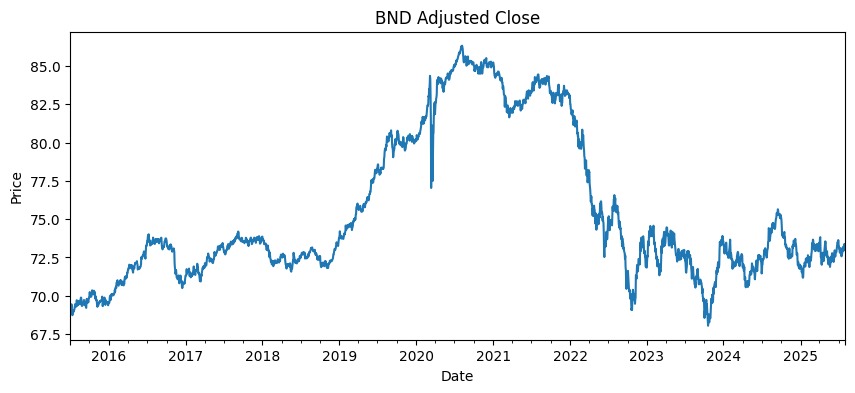

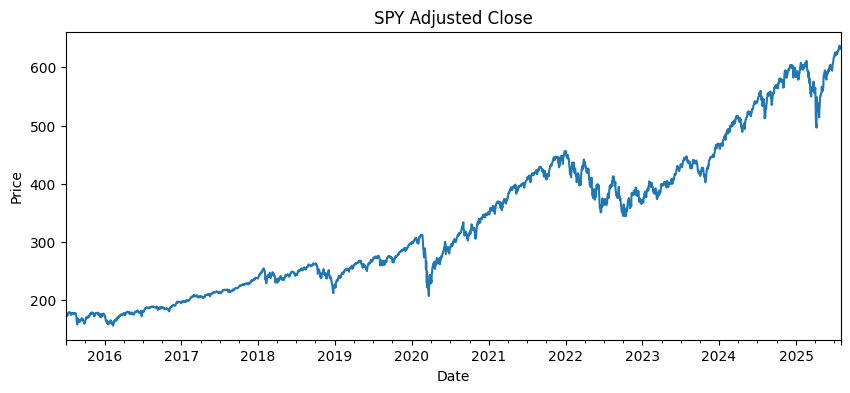

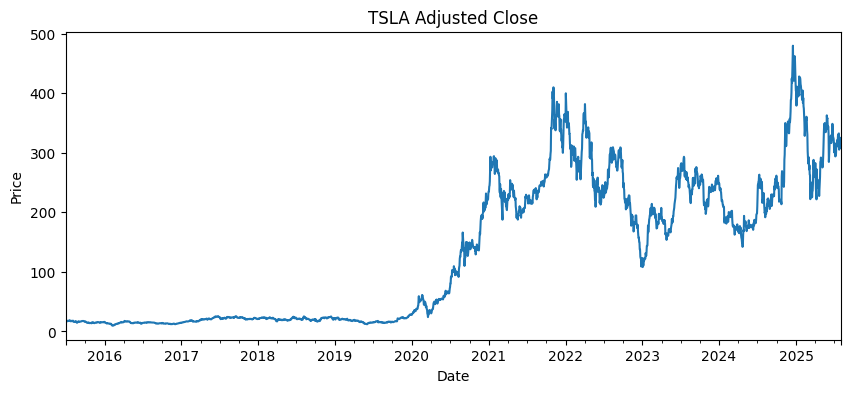

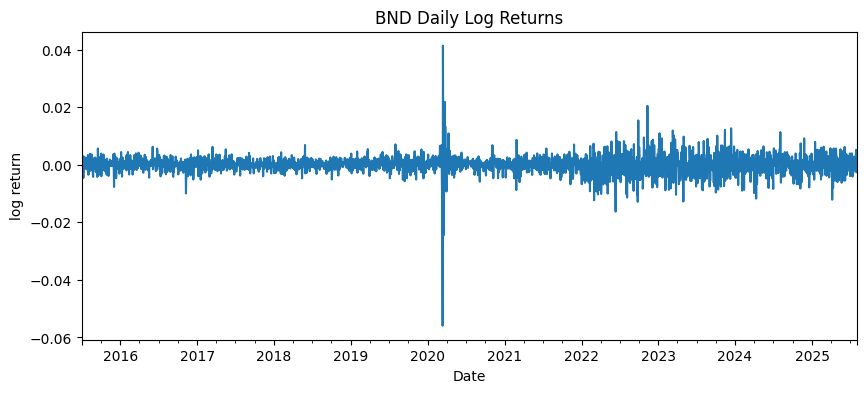

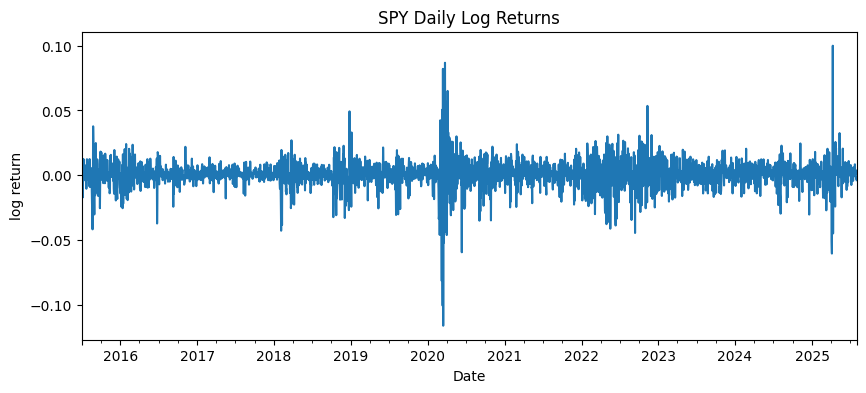

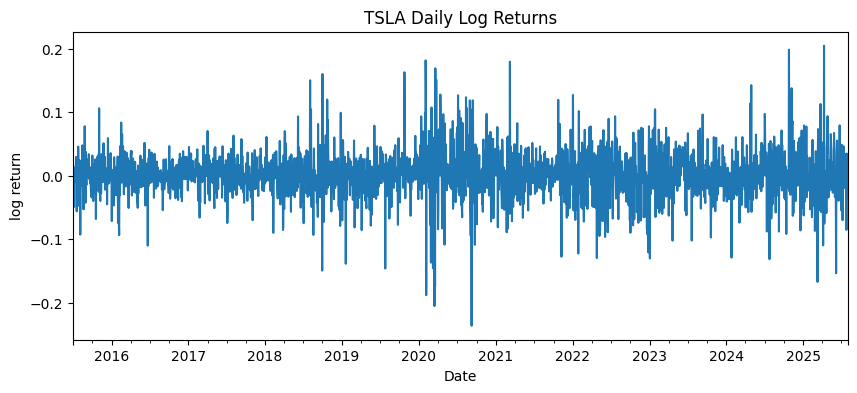

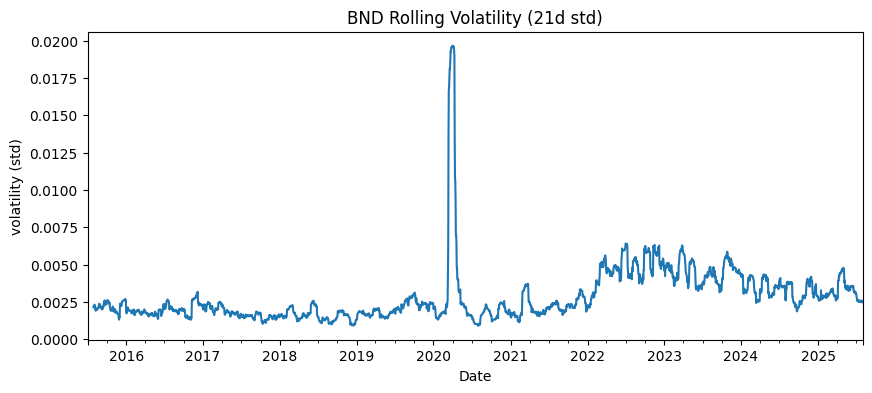

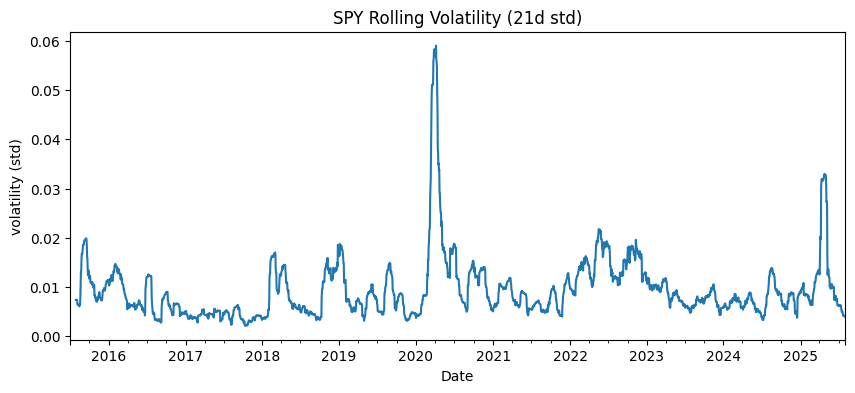

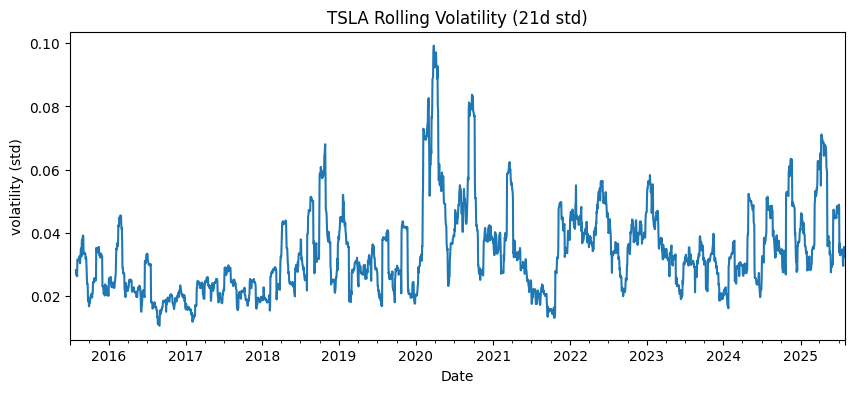

In [45]:
# No seaborn, one chart per figure (keeps rendering simple)
for c in close.columns:
    plt.figure()
    close[c].plot(title=f"{c} Adjusted Close")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.show()

for c in rets.columns:
    plt.figure()
    rets[c].plot(title=f"{c} Daily Log Returns")
    plt.xlabel("Date"); plt.ylabel("log return")
    plt.show()

for c in roll_vol.columns:
    plt.figure()
    roll_vol[c].plot(title=f"{c} Rolling Volatility (21d std)")
    plt.xlabel("Date"); plt.ylabel("volatility (std)")
    plt.show()


# Short narrative snippets (auto-filled with your live numbers)

In [46]:
def pct(x: float) -> str:
    return f"{100*x:.2f}%"

print("— Key Task 1 Notes —")
print(f"Window: {close.index.min().date()} → {close.index.max().date()} ({len(close)} business days)")

for c in rets.columns:
    sh = sharpe_annual(rets[c])
    vr = var_historical(rets[c])
    print(f"{c}: Sharpe={sh:.2f} | VaR95(1d)≈{pct(vr)} | mean daily={pct(rets[c].mean())}, std daily={pct(rets[c].std())}")

print("\nStationarity:")
print("Prices: typically non-stationary (need differencing for ARIMA on prices).")
print("Returns: typically stationary (often OK with d=0).")

# Provenance note you can paste into your memo
meta = {"sources_used": used_map,
        "window": {"start": str(close.index.min().date()), "end": str(close.index.max().date())}}
print("\nData provenance JSON:", json.dumps(meta))


— Key Task 1 Notes —
Window: 2015-07-01 → 2025-07-31 (2632 business days)
BND: Sharpe=0.11 | VaR95(1d)≈0.49% | mean daily=0.00%, std daily=0.34%
SPY: Sharpe=0.68 | VaR95(1d)≈1.71% | mean daily=0.05%, std daily=1.13%
TSLA: Sharpe=0.47 | VaR95(1d)≈5.48% | mean daily=0.11%, std daily=3.65%

Stationarity:
Prices: typically non-stationary (need differencing for ARIMA on prices).
Returns: typically stationary (often OK with d=0).

Data provenance JSON: {"sources_used": {"TSLA": {"symbol": "TSLA.US", "source": "stooq"}, "BND": {"symbol": "BND.US", "source": "stooq"}, "SPY": {"symbol": "SPY.US", "source": "stooq"}}, "window": {"start": "2015-07-01", "end": "2025-07-31"}}
